## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)
- [Resources](#resources)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
#To analyze the data, I will need to import the packages below.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#To read the df file and look at the first few rows.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#To check the shape of the dataframe, specifically just the rows.
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#To find out the numbers of unique users.
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
#To convert the proportion of users, using the mean.
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#To find the number of times new_page and treatment do not match.
df_not_match = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
df_not_match.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
#To check if they are any rows of missing values.
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**Answer:** No, there are no missing values in this dataset.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#To append and drop duplicates.
df2 = df.append(df_not_match).drop_duplicates(keep=False)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [9]:
#Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#To find the number of user_ids are in df2.
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#To find the repeated row.
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
#To find the whole row information of the repeated row.
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#To drop one of the duplicate rows.
df2 = df2.drop_duplicates(subset=['user_id'])

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#To find the probability of an individual converting.
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#To find the probability of an individual converted in the control group.
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#To find the probability of an individual converted in the treatment group.
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
#To find the probability of an individual landing on the new_page.
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer**: I cannot conclude that the new treatment page leads to more conversions because there is only a little difference between the individuals from control group and treatment control, not even full two decimal points.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} -  p_{old} ≤ 0$$
$$H_1: p_{new} -  p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
#To find the proportion of converted rate for p_new under under null.
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
#To find the proportion of converted rate for p_old under under null.
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [20]:
#To find the number of individuals in the treatment group.
n_new =  df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
#To find the number of individuals in the control group.
n_old =  df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
#To generate samples from a binomial distribution.
new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.11971646824031382

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
#To generate samples from a binomial distribution.
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.11861723364125722

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
#To use the mean to get the differences.
sim_diff = new_page_converted.mean() - old_page_converted.mean()
sim_diff

0.0010992345990566005

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
#To create sampling distribution of difference with bootstrapping.
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    new_page_p = new_page_converted.mean()
    old_page_p = old_page_converted.mean()
    p_diffs.append(new_page_p - old_page_p)

In [26]:
#To convert to numpy array.
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

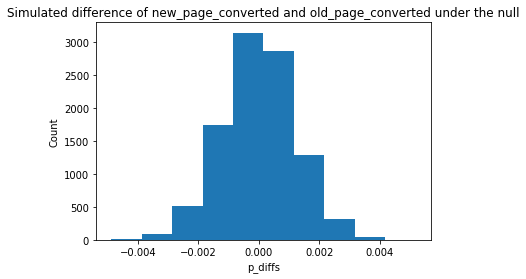

In [27]:
#To plot the sampling distribution.
plt.hist(p_diffs)
plt.title('Simulated difference of new_page_converted and old_page_converted under the null')#Histogram title
plt.xlabel('p_diffs') # x-axis label
plt.ylabel('Count'); # y-axis label

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
#To get the actual difference.
act_diff = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
act_diff

-0.0015782389853555567

In [29]:
#To convert to p_diffs to aaray.
p_diffs = np.array(p_diffs)
#To compute the p_value.
(p_diffs > act_diff).mean()

0.90490000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** I am computing the p-value. It is the probability of observing my statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. I would fail to reject the null hypothesis because there isn't strong evidence to prove there is a difference between the new and old pages since the p-value is greater than type I error threshold α (significance level of 0.05).

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

#The number of conversions for each page.
convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])

#The number of individuals in the each control from Part II c. and d.
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
#To compute the z_score and p_value.
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**: Both the z-score and p-value mean I would fail to reject the null. Yes, they are agree with the findings in part j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**: I should use Logistic Regression in this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#To add intercept column and create dummy variable column.
df2['intercept'] = 1
ab_page = ['treatment', 'control']
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
#To workaround the error I needed to import chisqprob.
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:24:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer**: The p-value associated with ab_page is 0.190 which is still greater than greater the type I error threshold α. However, the 0.190 is less than the p-value using z-score model because this logical regression model included an intercept.

$$H_0: p_{new} -  p_{old} = 0$$
$$H_1: p_{new} -  p_{old} != 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**: It is a good idea to consider other factors to add into my regression model because they may influence my hypotheses testing results in a positive way, making them more accurate. However, there are also disadvantages. A disadvantage would be multicollinearity which can lead to flipped regression coefficients from the expected relationships and inaccurate hypothesis testing results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
#To read the countries_df file.
countries_df = pd.read_csv('./countries.csv')
#To join the tables of contries_df with df2.
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
#To create the dummy variables.
df_new[['CA', 'UK', 'US']]  = pd.get_dummies(df_new['country'])
#To drop one of the columns.
df_new.drop('UK', axis = 1, inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [37]:
#To fit the linear model and get the results.
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:24:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

In [38]:
#To use reciprocal for negative values.
#Round 2 decimal places to interpret the results better.
(1/np.exp(results.params)).round(2)

intercept    7.24
ab_page      1.02
CA           1.05
US           1.01
dtype: float64

**Answer**: For ab_page, the conversion is 1.02 times more likely. For CA, the conversion is 1.05 times more likely. For US, the conversion is 1.01 times more likely. The p-values of them are greater than the type I error threshold α. There is no signficant impact.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
#To add other individual factors.
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['US_page'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,CA_page,US_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,0,0


In [40]:
#To fit the linear model with individual factors and get the results.
lm2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'CA', 'US', 'CA_page', 'US_page']])
results2 = lm2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        21:24:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In [41]:
#Only ab_page and US as they the only positive values.
#Round 2 decimal places to interpret the results better.
(np.exp(results2.params)).round(2)

intercept    0.14
ab_page      1.01
CA           0.99
US           1.01
CA_page      0.92
US_page      0.97
dtype: float64

In [42]:
#To use reciprocal for the negative values, all the variables except ab_page and US.
#Round 2 decimal places to interpret the results better.
(1/np.exp(results2.params)).round(2)

intercept    7.33
ab_page      0.99
CA           1.01
US           0.99
CA_page      1.08
US_page      1.03
dtype: float64

**Answer**: While holding all other variables constant, conversion is 1.08 times more likely for CA_page. All the p-values of the variables are greater than the type I error threshold α. There aren't any significant effects.

<a id='conclusion'></a>
### Conclusion
In conclusion, based on the statistical and practical reasonings above, I would still fail to reject both of the null hypotheses from Part II and III as they both are greater the type I error threshold α and do not show significant effects using the different testing models.

<a id='resources'></a>
### Resources
 - Numpy Documentation: https://numpy.org/doc/stable/
 - Pandas Documentation: https://pandas.pydata.org/docs/
 - Matplotlib Documentation: https://matplotlib.org/contents.html
 - W3cubDocs: https://docs.w3cub.com/statsmodels
 - SciPy: https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0